# Tutorial: Dynamic communicability and flow. Principles and basic examples.
Authors: **Matthieu Gilson** and **Gorka Zamora-López**

<img src="Images/UPFlogo_smaller.png" style="float:right; width:149px; height:50px"  alt="UPF logo" />
<img src="Images/HBPlogo_smaller.png" style="float:left; width:254px; heigth:50px " alt="HBP logo" />

<br/>
<br/>
<br/>



---------------------

This notebook is an introductory tutorial for the use of dynamic communicability and flow to study complex networks.

#### Outline
* DynComFlow library installation.
* Overview of basic concepts. 
* Example-1: Path graphs.
* Example-2: Ring-lattice and randomization.

--------------------

### Dependencies

The tutorial requires a Python 3.X installation together with NumPy and Matplotlib libraries. It also requires further in-house modules. [GAlib](https://github.com/gorkazl/pyGAlib) is a generic library for graph analysis. [NetDynFlow](https://github.com/mb-BCA/NetDynFlow) to estimate and study dynamic communicability and flow.


#### Import the main libraries

To get started, the first thing we need is to load the libraries we will need to work. Start importing the built-in and third party libraries.



In [1]:
from __future__ import division, print_function

from timeit import default_timer as timer
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import numpy.linalg


#### Import personal libraries

The following cells will check whether *GAlib* and *NetDynFlow* are already installed in the current working environment, otherwise, `pip` will be called for the installation (a working internet connection is required). **NOTE**: The exclamation mark ( ! ) before ``pip install galib`` indicates the Jupyter Notebook that the current line is a system command, which is then treated as if it were run from a terminal.


In [2]:
## Check if GAlib is installed in the current environment, otherwise install
try:
    import galib
except:
    # Install from PyPI
    print('Installing GAlib...')
    ! pip install galib
    import galib

In [3]:
import galib.models
import galib.tools

In [4]:
## Check if NetDynFlow is installed in the current environment, otherwise install
try:
    import netdynflow
except:
    # Install from the GitHub repository
    print('Installing NetDynFlow...')
    #! pip install git+https://github.com/mb-BCA/NetDynFlow.git@master
    ! pip install git+https://github.com/mb-BCA/NetDynFlow.git@version2

import netdynflow as ndf

In [5]:
# Explore the help functions of NetDynFlow
# ndf?
# ndf.core?
# ndf.metrics?

<br/>

## Overview of basic concepts

The aim of the present framework is to study and to characterise complex networks overcoming limitations of graph theory, specially concerning the study of weighted and directed networks. We characterise the structure by observing how perturbations propagate along a network. To do so, we need to assume a dynamic model on the network governing that propagation. We assume that every node behaves as a linear Ornstein-Uhlenbeck process fed by Gaussian noise. Given that $A$ is the connectivity matrix (weighted or unweighted, directed or undirected) the dynamics of a node follows: 

$\dot{x}_i = - \frac{x_i}{\tau} + \sum_{j=1}^N x_j + \xi_i $

where $\tau$ is a time-constant and $\xi_i$ is a Gaussian white noise, independent at each node. The role of $\tau$ is to control the rate of leakage through the nodes, thus counter-balancing the tendency of the linear connectivity to cause the divergence of the system.

**Dynamic flow** quantifies the generalised interactions between nodes over time in a network for arbitrary noisy inputs, considering either non-identical noise levels or even correlated inputs. **Dynamic communicability** corresponds to the special case in which all nodes receive independent noise of unit variance. Thus, dynamic communicability quantifies the network response to a unit stimulus (via the Green function). The following examples will emphasize a few basic properties:

- Dynamic communicability captures the evolution of the global network feedback over (integration) time.
- Node-wise input and output communicabilities capture the listening and broadcasting nature of nodes.
- Two nodes without a direct connection use to have non-zero interactions due to the network effects.
- Along integration time the dynamic communicability matrix is first dominated by node weights, then by network feedback and finally it becomes homogeneous.


For further reference and citation, see:

- M. Gilson, N. Kouvaris, G. Deco and G. Zamora-Lopez "*[Framework based on communicability and flow to analyze complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.052301)*" Phys. Rev. E **97**, 052301 (2018).
- M. Gilson, N. Kouvaris, et al. "*[Network analysis of whole-brain fMRI dynamics: A new framework based on dynamic communicability](https://doi.org/10.1016/j.neuroimage.2019.116007)*" NeuroImage **201**, 116007 (2019).



<br/>

## Example 1: First steps,  path (di)graphs

### Dynamic flow
We start by studying the flow and dynamic communicability on very simple graphs in order to understand basic concepts. Consider a chain graphs as the one with directed arcs in the figure below. We will characterise how a perturbation applied to the first node propagates along the chain.

<img src="Images/PathGraph_Directed1.png" style="float:center; width:500px; height:50px"  alt="Path Graph" />


In this first example we will: 
1. Create the digraph, 
2. calculate its spectral diameter to estimate the largest time-constant $\tau_{max}$ acceptable,
3. apply a perturbation at the first node,
4. explore the dynamic flow matrices over time, and 
5. visualise the node-wise input and output flows.

In [6]:
# Create a directed path graph of N = 6 nodes
N = 6
dirnet = galib.models.PathGraph(N, directed=True)

# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(dirnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:\t%2.5f' %evmax )
print( 'Largest possible tau:\t%2.5f' %maxtau )

Spectral radius:	0.00000
Largest possible tau:	inf


/Users/gorka/.edm/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


For a given network represented by $A$, the tendency of the network dynamics to diverge is represented by the largest eigenvalue (spectral radious) $\lambda_{max}$ of $A$. To assure the convergence of the system the leakage along each node needs to counterbalance this tendency. For that, the condicion $\tau < \tau_{max}$ with $\tau_{max} = 1 \,/\, \lambda_{max}$ needs to be fulfilled. 
In this particular case, all the eigenvalues of the directed path graph are zero, thus, $\tau_{max} = \infty$ and the system converges for any value of $\tau$. But this will not be the case in general.

In order to have a flow, we need to define an _**external perturbation**_, which is encoded in the $\Sigma$ matrix as the covariances between the external Gaussian noisy inputs. Since here we only want to excite the first node, $\Sigma$ will be all zeros exept for the element $\Sigma_{00} = 1$.

In [7]:
# Set the matrix of noisy inputs
sigma = np.zeros((N,N), np.float)
sigma[0,0] = 1.0

# Set a time-constant
tau = 1.0

# Define the temporal resolution for the "simulation"
tfinal = 10
dt = 0.01
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic flow for a time span between 0 and tmax
fullflow_dir = ndf.FullFlow(dirnet, tau, sigma, tmax=tfinal, timestep=dt, normed=True)
dynflow_dir = ndf.DynFlow(dirnet, tau, sigma, tmax=tfinal, timestep=dt, normed=True) 

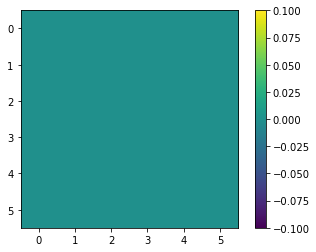

In [8]:
# Visualise the flow matrices at different times
plt.figure()
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
#pp.imshow(fullflow_dir[600])
plt.imshow(dynflow_dir[0])
plt.colorbar()


Text(0.5,0,'Time (a.u.)')

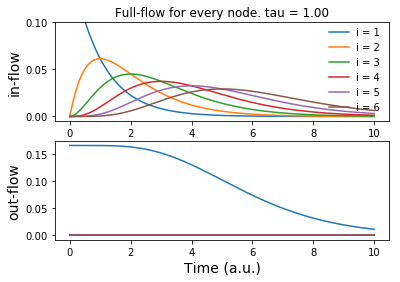

In [9]:
# Calculate the in-/out- full-flow for every node
# infullflow and outfullflow are two arrays of shape (N,nsteps)
infullflow_dir, outfullflow_dir = ndf.NodeEvolution(fullflow_dir)

# Plot a figure wit the input and output flows of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Full-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, infullflow_dir[:,i], label='i = %d' %(i+1))
plt.ylim(-0.005,0.1)
plt.ylabel('in-flow', fontsize=14)
plt.legend(frameon=False)

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints, outfullflow_dir[:,i], label='i = %d' %(i+1))
plt.ylabel('out-flow', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

Text(0.5,0,'Time (a.u.)')

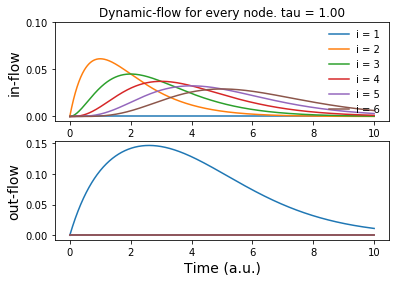

In [10]:
# Calculate the in-/out- dynamic-flow for every node
# inflow and outflow are two arrays of shape (N,nsteps)
inflow_dir, outflow_dir = ndf.NodeEvolution(dynflow_dir)

# Plot the input and output full-flow of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Dynamic-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, inflow_dir[:,i], label='i = %d' %(i+1))
plt.ylim(-0.005,0.1)
plt.ylabel('in-flow', fontsize=14)
plt.legend(loc='center right', frameon=False)

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints, outflow_dir[:,i], label='i = %d' %(i+1))
plt.ylabel('out-flow', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)


### Dynamic communicability

Flow is the general concept since it doesn't make any specific assumptions on which nodes are excited and even accepts correlated inputs across nodes (encoded as the extra-diagonal entries in $\Sigma$). We name *dynamic communicability* to the special case of the flow in which every node is perturbed by independent Gaussian noise of unit variance. The idea is illustrated as follows:

<img src="Images/PathGraph_Directed2.png" style="float:center; width:500px; height:50px"  alt="Path Graph" />

In this case, $\Sigma$ is the unitary matrix **1**. Therefore, the `ndf.DynCom()` function does not require the $\Sigma$ matrix as an explicit input.

We will now repeat the previous analysis for the new perturbation scheme.

In [11]:
# Calculate the dynamic communicability for a time span between 0 and tmax
dyncom_dir = ndf.DynCom(dirnet, tau, tmax=tfinal, timestep=dt, normed=True)

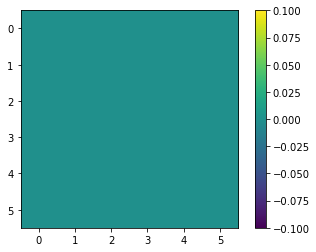

In [12]:
# Visualise the dynamic communicability matrices at different times
plt.figure()
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
plt.imshow(dyncom_dir[0])
plt.colorbar()


Text(0.5,0,'Time (a.u.)')

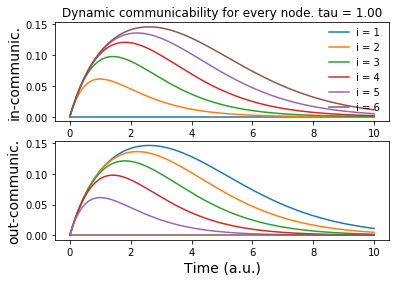

In [13]:
# Calculate the in-/out- dynamic communicability for every node
# indyncom and outdyncom are two arrays of shape (N,nsteps)
indyncom_dir, outdyncom_dir = ndf.NodeEvolution(dyncom_dir)

# Plot the input and output dynamic communicability of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Dynamic communicability for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, indyncom_dir[:,i], label='i = %d' %(i+1))
plt.ylabel('in-communic.', fontsize=14)
plt.legend(frameon=False)

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints, outdyncom_dir[:,i], label='i = %d' %(i+1))
plt.ylabel('out-communic.', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)


We end this introductory example by repeating the calculations on chains with _**undirected links**_ and following the same perturbation protocols.

<img src="Images/PathGraph_Undirected1.png" style="float:center; width:500px; height:50px"  alt="Path Graph" />
<img src="Images/PathGraph_Undirected2.png" style="float:center; width:500px; height:50px"  alt="Path Graph" />

In this case, the perturbations can diffuse in both directions. Also, the largest eigenvalue $λ_{max}$ of the path graph is finite, thus imposing a limitation on $\tau$.
$$$$


In [14]:
# Create the undirected path graph of N = 6 nodes
N = 6
undnet = galib.models.PathGraph(N, directed=False)

# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(undnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:\t%2.5f' %evmax )
print( 'Largest possible tau:\t%2.5f' %maxtau)

Spectral radius:	1.80194
Largest possible tau:	0.55496


In [15]:
# Set the matrix of noisy inputs
sigma = np.zeros((N,N), np.float)
sigma[0,0] = 1.0
# Set a time-constant
tau = 0.45

# Define the temporal resolution
tfinal = 10
dt = 0.01
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic flow for a time span between 0 and tmax
dynflow_und = ndf.DynFlow(undnet, tau, sigma, tmax=tfinal, timestep=dt, normed=True)
# Calculate the dynamic communicability for a time span between 0 and tmax
dyncom_und = ndf.DynCom(undnet, tau, tmax=tfinal, timestep=dt, normed=True)

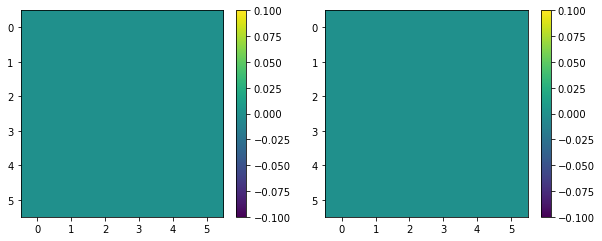

In [16]:
# Visualise the dynamic communicability matrices at different times
plt.figure(figsize=(10,3.8))

# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
tidx = 0

# Plot the flow matrix
plt.subplot(1,2,1)
plt.imshow(dynflow_und[tidx], aspect='auto')
plt.colorbar()

# Plot the flow matrix
plt.subplot(1,2,2)
plt.imshow(dyncom_und[tidx], aspect='auto')
plt.colorbar()

#plt.tight_layout()


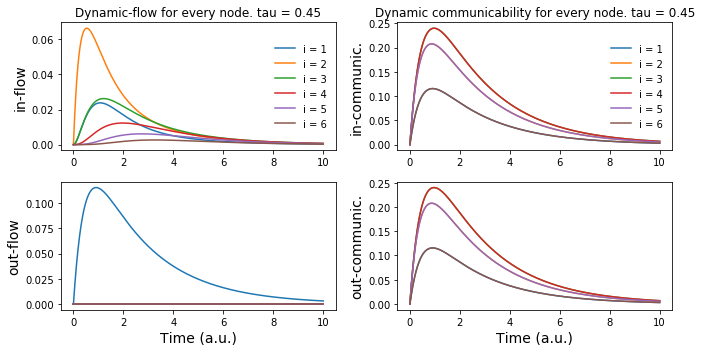

In [17]:
# Calculate the in-/out- dynamic flow and communicability for every node
inflow_und, outflow_und = ndf.NodeEvolution(dynflow_und)
indyncom_und, outdyncom_und = ndf.NodeEvolution(dyncom_und)

# Plot the input and output results for every node
plt.figure(figsize=(10,5))
# Plot the results for the in-/out-flow
plt.subplot(2,2,1)
plt.title('Dynamic-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, inflow_und[:,i], label='i = %d' %(i+1))
#pp.ylim(-0.005,0.1)
plt.ylabel('in-flow', fontsize=14)
plt.legend(loc='center right', frameon=False)

plt.subplot(2,2,3)
for i in range(N):
    plt.plot(tpoints, outflow_und[:,i], label='i = %d' %(i+1))
plt.ylabel('out-flow', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

# Plot the results for the in-/out-dynamic communicability
plt.subplot(2,2,2)
plt.title('Dynamic communicability for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, indyncom_und[:,i], label='i = %d' %(i+1))
plt.ylabel('in-communic.', fontsize=14)
plt.legend(loc='center right', frameon=False)

plt.subplot(2,2,4)
for i in range(N):
    plt.plot(tpoints, outdyncom_und[:,i], label='i = %d' %(i+1))
plt.ylabel('out-communic.', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

plt.tight_layout()


<br/>

## Example 2: Weighted ring lattices and comparison to surrogates

Now we will consider ring networks where links are weighted. We will:

1. Create and study a directed ring with random link weights.
2. Create and study an undirected ring with random link weights.
3. Compare to weighted open loops (weighted path graphs).
4. Randomise links and compare.
5. Add further connectivity.


### Directed ring with weighted links

We start by studying a directed ring whose links are weighted, see illustration below. The link weights will be randomly assigned from a normal distribution with mean `c0` and variance `w_spread`. In this case the global feedback is thus controled by `c0` and the heterogeneity of weights by `w_spread`.


<img src="Images/RingDigraph.png" style="float:center; width:200px; height:200px"  alt="Directed Ring" />


Setting the number of nodes to *N = 4* would reproduce results in Figs. 2 and 3 in the paper:  Gilson M, Kouvaris NE, Deco G, Zamora-López G (2018) *Phys Rev E* **97**, 052301 (https://doi.org/10.1103/PhysRevE.97.052301).



Text(0,0.5,'Source node')

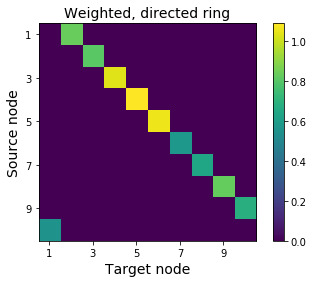

In [18]:
# Create a directed ring with random link weights
N = 10
c0 = 0.8
w_spread = 0.4

C_dir = np.zeros([N,N])
for i in range(N):
    C_dir[i-1,i] = c0 * (1 + 2*w_spread*(np.random.rand() - 0.5))

# Visualise the connectivity matrix
axticks = np.arange(0,N,2)

plt.figure()
plt.title('Weighted, directed ring', fontsize=14)
plt.imshow(C_dir, interpolation='nearest')
plt.xticks(axticks, axticks+1, fontsize=10)
plt.yticks(axticks, axticks+1, fontsize=10)
plt.colorbar()
plt.xlabel('Target node', fontsize=14)
plt.ylabel('Source node', fontsize=14)



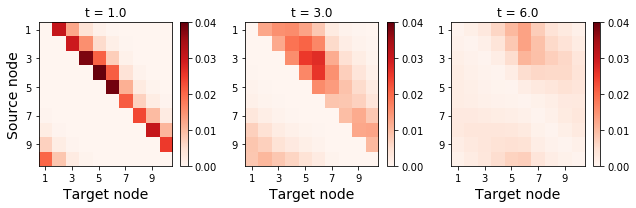

In [19]:
# Calculate the dynamic communicability 
# Define the temporal resolution for the "simulation"
tfinal = 20
dt = 0.2
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Set a time-constant for the leakage at the nodes
tau = 1.0

# Calculate dynamic communicability
dc_dir = ndf.DynCom(C_dir, tau, tmax=tfinal, timestep=dt)

# Visualise the communicability matrix at three different integration times
plt.figure(figsize=(9,3))
axticks = np.arange(0,N,2)
for idx, t in enumerate([1,3,6]):
    plt.subplot(1,3,idx+1)
    plt.title('t = %1.1f' %t, fontsize=12)
    plt.imshow(dc_dir[int(t/dt)], interpolation='nearest', aspect='auto', cmap='Reds')
    plt.clim(0, 0.04)
    plt.xticks(axticks, axticks+1, fontsize=10)
    plt.yticks(axticks, axticks+1, fontsize=10)
    plt.colorbar(ticks=[0,0.01,0.02, 0.03, 0.04])
    plt.xlabel('Target node', fontsize=14)
    if idx==0: plt.ylabel('Source node', fontsize=14)

plt.tight_layout()


#### Network and node-wise characterization with dynamic communicability

The coarse-grained, general behaviour of the network over time can be evaluated by _**total communicability**_, which is defined as the sum of all pair-wise interactions between nodes. Thus, total communicability characterises the global network feedback. In this example it depends on the mean link weight `c0`.

The communicability passing through a node depends not only on its closest neighbours, but reflects the role that each node plays in the global communication of the network. The temporal evolution of a node's communicability is calculated as the "row" or "column" sum of the communicability matrix, at each time point. If the network is symmetric, both sums will be the same. If the network is directed (asymmetic), then input (column sum) and output (row sum) communicabilies reflect a node's capacity to integrate or to broadcast information respectively.

In the following, we will show the total and node-wise communicability of the weigthed and directed ring we just created.

Text(0,0.5,'total communicability')

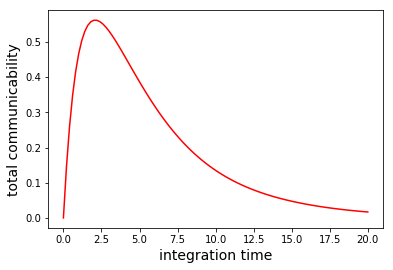

In [20]:
# Calculate total communicability. Use the generic function to estimate tensor sum over time.
totcomm_dir = ndf.TotalEvolution(dc_dir)

plt.figure()
plt.plot(tpoints, totcomm_dir, color='red')
plt.xlabel('integration time', fontsize=14)
plt.ylabel('total communicability', fontsize=14)


Text(0.5,1,'Output communicability')

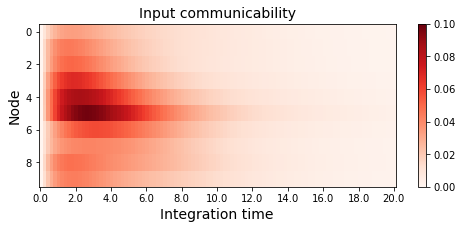

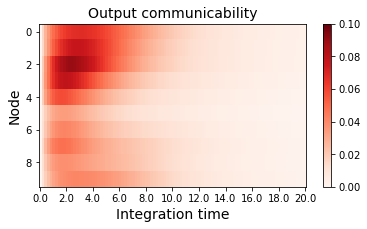

In [33]:
# Calculate the input and output communicabilities for each node, over integration time
# Use the generic function to estimate node-wise averages from the time-flow tensor
in_dc, out_dc = ndf.NodeEvolution(dc_dir)

# Visualise the in-/out-communicabilities as an image
xtick_idx = np.arange(0,nsteps+1,10)
xtick_labs = tpoints[xtick_idx]

# Plot the input communicabilities
plt.figure(figsize=(8,3))
plt.imshow(in_dc.T, aspect='auto', cmap='Reds', vmin=0, vmax=0.1)
plt.xticks(xtick_idx, xtick_labs)
plt.xlabel('Integration time',fontsize=14)
plt.ylabel('Node', fontsize=14)
plt.colorbar()
plt.title('Input communicability', fontsize=14)

# Plot the output communicabilities
plt.figure(figsize=(8,3))
plt.imshow(out_dc.T, aspect='auto', cmap='Reds', vmin=0, vmax=0.1)
plt.xticks(xtick_idx, xtick_labs)
plt.xlabel('Integration time', fontsize=14)
plt.ylabel('Node',fontsize=14)
plt.colorbar()
plt.title('Output communicability', fontsize=14)


#### Diversity

As we saw before, the communicability matrices change over time. Initially the interactions tend to be aligned with the links in the connectivity matrix. At later integration times the interactions capture nontrivial network feedback, and finally the pattern of interactions homogenises. We quantify the heterogeneity of pair-wise communicabiltiy values as the coefficient of variance in the communicability matrix at each time; a metric we refer as _**diversity**_.

We now show a direct comparison between the original link weights in the connectivity matrix `C` and the values that the pair-wise communicability take; illustrating its process of homogeneization over time.

Text(0,0.5,'Diversity')

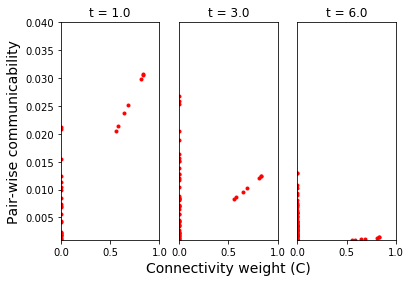

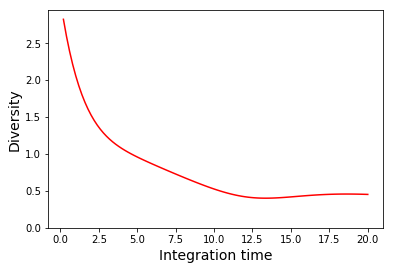

In [22]:
# Plot the comparison between the connectivity weights and communicability over time.
plt.figure()
for i, t in enumerate([1,3,6]):
    plt.subplot(1,3,i+1)
    plt.plot(C_dir, dc_dir[int(t/dt)], '.r')
    if i==1:
        plt.xlabel('Connectivity weight (C)', fontsize=14)
    if i==0:
        plt.ylabel('Pair-wise communicability', fontsize=14)
    else:
        plt.yticks([])
    plt.axis(xmin=-0.001, xmax=1, ymin=0.001, ymax=0.04)
    plt.title('t = %1.1f' %t)


# Compute the diversity over time from the dyn. comm. tensor
divers = ndf.Diversity(dc_dir)

# Plot the temporal evolution of the diversity
plt.figure()
plt.plot(tpoints, ndf.Diversity(dc_dir), color='r')
plt.axis(ymin=0)
plt.xlabel('Integration time', fontsize=14)
plt.ylabel('Diversity', fontsize=14)


### Undirected ring with weighted links

We now repeat the analysis considering the ring network is **undirected**, as in the figure below. The undirected ring will be constructed symmetrising the directed ring we created before. **Notice that** the symmetrization conserves the total weight of matrix.

<img src="Images/RingGraph.png" style="float:center; width:200px; height:200px"  alt="Undirected Ring" />


Text(0,0.5,'Source node')

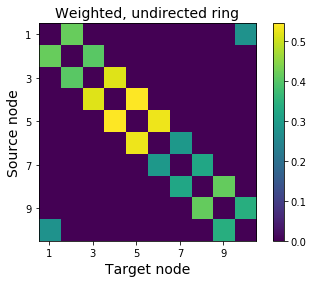

In [23]:
# Create the symmetric version of the original directed ring
C_sym = 0.5 * (C_dir + C_dir.T)

# Visualise the new connectivity matrix
axticks = np.arange(0,N,2)

plt.figure()
plt.title('Weighted, undirected ring', fontsize=14)
plt.imshow(C_sym, interpolation='nearest')
plt.xticks(axticks, axticks+1, fontsize=10)
plt.yticks(axticks, axticks+1, fontsize=10)
plt.colorbar()
plt.xlabel('Target node', fontsize=14)
plt.ylabel('Source node', fontsize=14)



Text(0,0.5,'Total communicability')

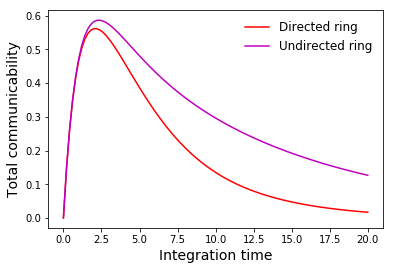

In [24]:
# Compare the dynamic communicability for directed and undirected cases
# Calculate DC for the symmetric network - using same temporal resolution
dc_sym =  ndf.DynCom(C_sym, tau, tmax=tfinal, timestep=dt)

# Calculate total communicability. Use the generic function to estimate tensor sum over time.
totcomm_sym = ndf.TotalEvolution(dc_sym)


# Visualise the comparison
plt.figure()
plt.plot(tpoints, totcomm_dir, c='r', label='Directed ring')
plt.plot(tpoints, totcomm_sym, c='m', label='Undirected ring')
plt.legend(frameon=False, fontsize=12)
plt.xlabel('Integration time', fontsize=14)
plt.ylabel('Total communicability', fontsize=14)


As seen, the undirected ring achieves larger total communicability due to the reinforced recurrent feedback created when making the links bidirectional.
Finally, we confirm that in the symmetrised case the input and output node communicabilities are symmetric, and different from the original directed case.

Text(0.5,1,'Output communicability')

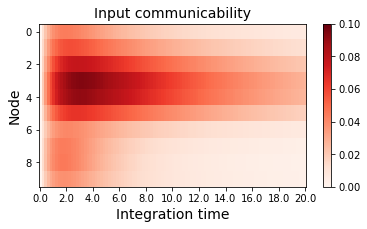

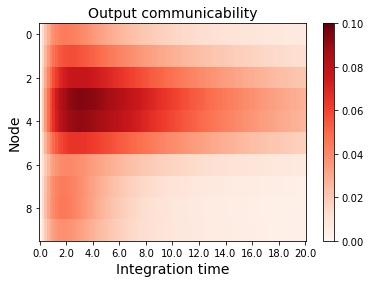

In [31]:
# Calculate the communicabilities for each node, over integration time
# Use the generic function to estimate node-wise averages from the time-flow tensor
in_dcsym, out_dcsym = ndf.NodeEvolution(dc_sym)

# Visualise the in-/out-communicabilities as an image
xtick_idx = np.arange(0,nsteps+1,10)
xtick_labs = tpoints[xtick_idx]

# Plot the input communicabilities
plt.figure(figsize=(8,3))
plt.imshow(in_dcsym.T, aspect='auto', cmap='Reds', vmin=0, vmax=0.1)
plt.xticks(xtick_idx, xtick_labs)
plt.xlabel('Integration time',fontsize=14)
plt.ylabel('Node', fontsize=14)
plt.colorbar()
plt.title('Input communicability', fontsize=14)

# Plot the output communicabilities
plt.figure(figsize=(8,3))
plt.imshow(out_dcsym.T, aspect='auto', cmap='Reds', vmin=0, vmax=0.1)
plt.xticks(xtick_idx, xtick_labs)
plt.xlabel('Integration time', fontsize=14)
plt.ylabel('Node',fontsize=14)
plt.colorbar()
plt.title('Output communicability', fontsize=14)



<br>

### Weighted open loops (path graphs)

GORKA: MAN, THIS IS BASICALLY A PATH GRAPH! WE SHOULD HAVE ADDED A WEIGHTED VERSION?

Now we remove a connection and redistribute its value to other nodes, keeping the total weight constant. The obtaine dopen loop has a much smaller total communicability.

In [26]:
C_opendir = np.copy(C_dir)
C_opendir[-1,0] = 0
C_opendir *= C_dir.sum() / C_opendir.sum()

C_opensym = np.copy(C_sym)
C_opensym[-1,0] = 0
C_opensym *= C_sym.sum() / C_opensym.sum()





Text(0,0.5,'Total communicability')

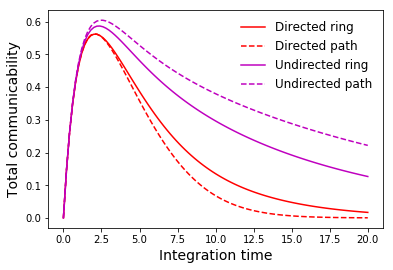

In [27]:
# calculate dynamic communicability
dc_opendir =  ndf.DynCom(C_opendir, tau, tmax=tfinal, timestep=dt)
dc_opensym =  ndf.DynCom(C_opensym, tau, tmax=tfinal, timestep=dt)

totcomm_opendir = ndf.TotalEvolution(dc_opendir)
totcomm_opensym = ndf.TotalEvolution(dc_opensym)

# comparison of total communicability for the 3 configurations

# Visualise the comparison
plt.figure()
plt.plot(tpoints, totcomm_dir, c='r', label='Directed ring')
plt.plot(tpoints, totcomm_opendir, c='r', ls='--', label='Directed path')
plt.plot(tpoints, totcomm_sym, c='m', label='Undirected ring')
plt.plot(tpoints, totcomm_opensym, c='m', ls='--', label='Undirected path')
plt.legend(frameon=False, fontsize=12)
plt.xlabel('Integration time', fontsize=14)
plt.ylabel('Total communicability', fontsize=14)



### Rewiring of the networks

Now we rewire the network some of the existing connections to random nodes.

The outcome may be an decrease of total communicability when the rewiring leads to an open loop or increased total communicability when it yields clusters of strongly connected nodes (with several closed loops).

In [28]:
p_rew = 0.3 # probability of rewiring (random network with p_rew=1)

# rewiring C with probability p_rew for each existing connection
C_rew = np.zeros(C.shape)
for i in range(N):
    for j in range(N):
        if C[i,j] > 0:
            if np.random.rand() < p_rew:
                i_rew = np.random.randint(N)
                j_rew = np.random.randint(N)
                while j_rew == i_rew:
                    j_rew = np.random.randint(N)
                C_rew[i_rew,j_rew] += C[i,j]
            else:
                C_rew[i,j] += C[i,j]

# calculate dynamic communicability
dc_rew =  ndf.DynCom(C_rew, tau, tmax=tfinal, timestep=dt)

# rewired Jacobian
J_rew = -np.eye(N) / tau + C_rew

plt.figure(figsize=[3,3])
plt.axes([0.2,0.25,0.65,0.65])
plt.imshow(J_rew,origin='lower',interpolation='nearest',vmin=-1,vmax=1,cmap='bwr')
plt.xticks(range(N),np.arange(N)+1,fontsize=12)
plt.yticks(range(N),np.arange(N)+1,fontsize=12)
plt.colorbar()
plt.xlabel('target node',fontsize=12)
plt.ylabel('source node',fontsize=12)

# comparison of total communicability for the 3 configurations

plt.figure()
plt.plot(tpoints, ndf.TotalEvolution(dc), c='r')
plt.plot(tpoints, ndf.TotalEvolution(dc_sym), c='m')
plt.plot(tpoints, ndf.TotalEvolution(dc_open), c='b')
plt.plot(tpoints, ndf.TotalEvolution(dc_rew), c='g')
plt.legend(['original','symmetric','open loop','rewired'])
plt.xlabel('integration time')
plt.ylabel('total communicability')


NameError: name 'C' is not defined

### Comparison with ring lattice connected up to several neighbors

Now we come back to the original ring network and replace the single connection with the preceeding neighbor by several connections with the preceeding neighbors. This gives the same total communicability, but gives faster homogenization of the interactions between the nodes, which is reflected in the diversity.

In [ ]:
n = 2 # number of neighbors to connect (preceeding neighbors in the index order)

# create random connectivity matrix
C_n = np.zeros([N,N])
for j in range(N): # target node
    for i in range(j-n,j): # preceeding neighbors
        C_n[i,j] = C[i-1,i] / n # connection from i to j

# calculate dynamic communicability
dc_n =  ndf.DynCom(C_n, tau, tmax=tfinal, timestep=dt)

# Jacobian
J_n = -np.eye(N) / tau + C_n

plt.figure(figsize=[3,3])
plt.axes([0.2,0.25,0.65,0.65])
plt.imshow(J_n,origin='lower',interpolation='nearest',vmin=-1,vmax=1,cmap='bwr')
plt.xticks(range(N),np.arange(N)+1,fontsize=12)
plt.yticks(range(N),np.arange(N)+1,fontsize=12)
plt.colorbar()
plt.xlabel('target node',fontsize=12)
plt.ylabel('source node',fontsize=12)

# comparison of total communicability for the 3 configurations
plt.figure()
plt.plot(tpoints, ndf.TotalEvolution(dc), c='r')
plt.plot(tpoints, ndf.TotalEvolution(dc_sym), c='m')
plt.plot(tpoints, ndf.TotalEvolution(dc_open), c='b')
plt.plot(tpoints, ndf.TotalEvolution(dc_rew), c='g')
plt.plot(tpoints, ndf.TotalEvolution(dc_n), c='c', ls='-.')
plt.legend(['original','symmetric','open loop','rewired','multiple neighbors'])
plt.xlabel('integration time')
plt.ylabel('total communicability')

# communicability matrix at 3 integration times
for t in [1,3,6]:
    plt.figure(figsize=[3,3])
    plt.axes([0.2,0.25,0.65,0.65])
    plt.imshow(dc_n[int(t/dt)],origin='lower',interpolation='nearest',vmin=0,vmax=0.02,cmap='Reds')
    plt.xticks(range(N),np.arange(N)+1,fontsize=12)
    plt.yticks(range(N),np.arange(N)+1,fontsize=12)
    plt.colorbar(ticks=[0,0.01,0.02])
    plt.xlabel('target node',fontsize=12)
    plt.ylabel('source node',fontsize=12)
    plt.title('integration time '+str(t),fontsize=12)


In [ ]:
# diversity
plt.figure()
plt.plot(tpoints, ndf.Diversity(dc), c='r')
plt.plot(tpoints, ndf.Diversity(dc_sym), c='m')
plt.plot(tpoints, ndf.Diversity(dc_open), c='b')
plt.plot(tpoints, ndf.Diversity(dc_rew), c='g')
plt.plot(tpoints, ndf.Diversity(dc_n), c='c')
plt.legend(['original','symmetric','open loop','rewired','multiple neighbors'])
plt.xlabel('integration time')
plt.ylabel('communicability diversity')


Interestingly, the homogenization is quicker for the unidirectional loop with 2 neighbors than the symmetric loop, which also has two neighbors. This comes from the fact that the activity at a given node affect more distant nodes in the former configuration.

Note that diversity diverges for the open loop, which comes from the fact that the mean of the communicability interactions decreases too quickly over time.